# 04_Flood_Depth_ModelTraining: Trucks

In this notebook, images are prepared, a model is built and trained, the model and weights are saved, and the model is evaluated.

Building an image classification model is a mix of art and science. In some cases, a prebuilt model and previously saved model weights are used (transfer learning). In this project, we have opted to start with a model framework but to train and determine the model weights ourselves.

This model leverages the work of the VGG-16 model, published in 2015 as

    Very Deep Convolutional Networks for Large-Scale Image Recognition    
    K. Simonyan, A. Zisserman    
    arXiv:1409.1556

This model became very popular because it reported >90% accuracy on several test sets. It has been successfully used on a number of other test sets since then.

Implementation and enhancement examples from the following sources were also used, including methods to save and restore models, weights, augment images, and exit early from a training session.

 - https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c
 - https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
 - https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3
 
Building on the material from these sources, we have modified the code, built additional utilities, and generally customized everything.

## Contents:    
 1. Notebook Setup
 1. Image Setup
 1. Model Build
 1. Model Train
 1. Model Evaluation
 1. Conclusion

# 1. Notebook Setup

## Import

In [1]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.preprocessing import image

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report

Using TensorFlow backend.


In [2]:
keras.__version__

'2.3.1'

In [3]:
# import tensorflow       # not required in this flow
# tensorflow.__version__  # 2.2.0

## Global settings

In [4]:
# File names can be changed to experiment without overwriting last known good models
# CAUTION:
# full models are 1.5G+
# model weights are 500M+

final_model_full = 'model_final_truck.h5'

final_model_weights = 'model_final_truck_weights.h5'

checkpoint_model_full = 'model_best_truck.h5'

checkpoint_model_weights = 'model_best_truck_weights.h5'

In [5]:
# Images for training the model
train_dir = '../images/trucks/train'

# Images for validating the model (testing it during the training phases)
validate_dir = '../images/trucks/validate'

# After the model has been built, try it out on a few images it hasn't seen
image_test_dir = '../images/trucks/test'

## Utility functions

In [6]:
# Remove .DS_store from the list of files in a directory
def rm_DS(mlist): 
    if ('.DS_Store' in mlist): mlist.remove('.DS_Store')
    return mlist

In [7]:
# For reproducibility during development and testing, do not change this value.
np.random.seed(2020)

# 2. Image setup

## Locate images

The folder structure beneath each of the train, validate, and test directories is identical, and each folder represents a category for classification.

We have standardized on estimating flood depths as

|Category|Meaning|
|---|---|
|depth_0| No water, or surface water on the order of 1 inch.|
|depth_1| 1 foot, or approximately the middle of a hubcap.|
|depth_2| 2 feet, or approximately the top of a tire.|
|depth_3| 3 feet, or roughly just below the side view mirrors or the top of the door.|
|depth_4| 4 feet, or above the truck bed but below the roof line.|

In [8]:
!ls {train_dir}  # folders in the train_dir indicate the classification categories 
                 # if this command does not work in your environment, comment out this cell

depth_0 depth_1 depth_2 depth_3 depth_4


In [9]:
# Programmatically get the class labels from the training directory
category_list = rm_DS(os.listdir(image_test_dir))
labels = sorted(category_list)
num_categories = len(labels)

print(f"Classification labels to predict: {labels}")

Classification labels to predict: ['depth_0', 'depth_1', 'depth_2', 'depth_3', 'depth_4']


In [10]:
# Count the number of images in each category; determine the baseline model
image_train_dirs = os.listdir(train_dir)

category_dict = dict()
total_images = 0

for itdir in image_train_dirs:
    checkdir = train_dir + '/' + itdir
    if (itdir != '.DS_Store'):
        num_images = len(os.listdir(checkdir))
        category_dict[itdir] = num_images
        total_images += num_images
        
print(f"Total images: {total_images}")
baseline = 0
for k,v in category_dict.items():
    prcnt = round(100*v/total_images,1)
    print(f"Category {k} has {v: 3d} images or {prcnt}% of the images.")
    if prcnt > baseline: baseline = prcnt
        
print(f"\nBaseline accuracy: {baseline}%")
print(f"(accuracy achieved by simply guessing the most populous category)")

Total images: 66
Category depth_2 has  14 images or 21.2% of the images.
Category depth_3 has  17 images or 25.8% of the images.
Category depth_4 has  13 images or 19.7% of the images.
Category depth_1 has  13 images or 19.7% of the images.
Category depth_0 has   9 images or 13.6% of the images.

Baseline accuracy: 25.8%
(accuracy achieved by simply guessing the most populous category)


## Image pre-processing

Inspiration for ways to augment a small data set:
    
 - https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
    
 - https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html   

**ImageDataGenerator**

When working with a small number of images, one option is to randomly transform the images (by reasonable amounts) to imitate having a larger data set.

In the following section, the ImageDataGenerator will be configured to include minor random changes to the images:
 - width_shifts (side to side shifts of the image)
 - height
 - rotation (up to 4 degrees)
 - horizontal_flip
 
Note that these transformations are in addition to the transforms that created the augmented data set. For example, some of the images could be rotated (during augmentation) and flipped (by the ImageDataGenerator).
 
The ImageDataGenerator expects a very clear set of directories to work from, and in return it provides a very easy way for the model to use the training files without modifying them. The data will be modified 'on the fly' when being passed into the model.

In [11]:
# The bulk of the images are in the training set
print("Preparing TRAIN data...")
trdata = ImageDataGenerator(
                            width_shift_range=0.1,     # can create h-stripes
                            height_shift_range=0.1,
                            channel_shift_range = 0.0, # 0.0 no RGB shifts
                            rotation_range=4,
                            horizontal_flip=True
)
traindata = trdata.flow_from_directory(
        directory=train_dir, 
        target_size=(224,224)  # images will be reduced to this
        )

print()
# This data is used to validate the model during training
print("Preparing VALIDATION data...")
tsdata = ImageDataGenerator(
                            width_shift_range=0.1, # additional mods are randomly added
                            height_shift_range=0.1,
                            rotation_range=4,
                            horizontal_flip=True
                           )
testdata = tsdata.flow_from_directory(
        directory=validate_dir,
        target_size=(224,224)
        )

Preparing TRAIN data...
Found 61 images belonging to 5 classes.

Preparing VALIDATION data...
Found 32 images belonging to 5 classes.


Preview a few training images; may include slight shifts or rotations.


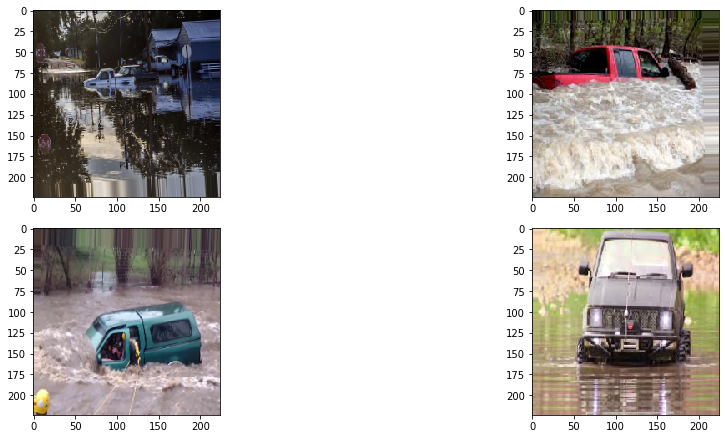

In [12]:
# Preview a few training images
num_preview_images = 4

print("Preview a few training images; may include slight shifts or rotations.")

# take a quick look at the the testdata images
fig = plt.figure(figsize=(14,2*num_preview_images+1))

#it = testdata.flow(batch_size=1)
img_count = 1;

for i in range(num_preview_images):
    ax = fig.add_subplot((num_preview_images/2)+1,2,img_count)
    
    getphoto = traindata.next()
    getimg = getphoto[0].astype('uint8')[img_count]
    ax.imshow(getimg)
    img_count += 1
plt.tight_layout()

# 3. Model Build

The VGG16 model is a Convolutional Neural Net (CNN) architecture. We can envision this as built in 4 sections:
    
1.  **convolution and maxpooling**
   - Convolution layers will operate on a small area of cells (3x3 in this case), and combine the pixel values into a single value. This is repeated at single steps across the entire image, resulting in a final set of values that is slightly smaller than the incoming image. The 'ReLU' activation function which determines how the values are combined is a common choice as it works well and is fast to compute.
   - Maxpooling layers will further shrink the image by taking the maximum value of a small area of cells (2x2 in this case) and repeating this across the image.
   - VGG16 uses 5 repeats of this pattern: 2 or 3 Convolution + 1 Maxpooling    
   - The model.summary cell includes the "Output Shape" for each layer and the effect of the convolution + maxpool downsizing can be seen.
     
      
2.  **flatten**
   - A flatten layer is required to transition from the convolutional layers to the dense layers. This step transforms a 2D image into a single 1D array of values.    
   - The model.summary cell confirms that this is now a 1D array of length 25088.
     
       
3.  **dense layers**
   - Dense layers are the true "neural nets" of the model, where every neuron is connected to every neuron in the previous layer.    
   - The model.summary cell confirms that there are no changes in layer size for dense layers.
         
          
4.  **softmax layer**
   - The final dense layer is slightly different; all inputs are channeled to a limited number of outputs. In this case, since we are predicting 5 classes, there are only 5 final values. This layer uses the 'softmax' activation function which will ensure that all probabilities are between 0 and 1 and they all add up to 1. The final prediction is based on which class has the highest predicted probability.
   - The model.summary cell confirms that the final layer has only 5 outputs.

In [13]:
model = Sequential()

model.add(Conv2D(input_shape=(224,224,3),
                 filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

In [14]:
model.add(Flatten())

model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))

model.add(Dense(units=num_categories, activation="softmax")) # units needs to be the same as the num classes

At the end of the cell above, the "softmax" activation layer contains the name number of nodes as the 'num_categories', and this is where the final classification will occur. At this point, the model layers have been built. The next step is to compile the model.

In [15]:
# Compile the model with the model parameters
opt = Adam(lr=0.0001)
model.compile(optimizer=opt, 
              loss=keras.losses.categorical_crossentropy, 
              metrics=['accuracy']                        # other metrics to produce
             )

'Adam' is a popular optimiser for finding the global minimum of the loss function.

The learning rate may be adjusted 
- lower, if the results are changing drastically from epoch to epoch
- higher, if the model runs for a very long time and doesn't make very much progress from epoch to epoch

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 256)      

# 4. Model Training

**ModelCheckpoint and EarlyStopping**      
These methods can be called during model training ('callback functions'). 

**ModelCheckpoint**     
This function will monitor a selected parameter and save a copy of the model if there was an improvment from the prior epoch to the current epoch. If the parameter stops improving, changes in the model will not be saved. In essence, this captures the model that provided the best results (for the selected parameter) during the training sessions.

**EarlyStopping**    
This function can terminate training early if the progress is too slow. It will monitor the selected parameter, be patient enough to wait for a specified number of epochs, and then stop the training if the parameter hasn't improved.

In [17]:
# Fit the model

# Save the model if the validation accuracy has improved over the previous epoch
checkpoint = ModelCheckpoint(checkpoint_model_full, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)

# Stop training early if the validation accuracy has not improved
early = EarlyStopping(monitor='val_accuracy',  # parameter to monitor
                      min_delta=0,             # minimum improvment
                      patience=20,             # how many epochs to wait
                      verbose=1, mode='auto')

use_epochs = 25 # original had 100
#steps_per_epoch = num_train_images / use_epochs # calculate well or leave it blank

m_history = model.fit_generator(
                           #steps_per_epoch=steps_per_epoch,
                           generator=traindata,           # training images
                           validation_data= testdata,     # validation images
                           #validation_steps=10,           #
                           epochs=use_epochs,             # training cycles
                           callbacks=[checkpoint,early]
                    )

Epoch 1/25
2/2 [==============================] - 19s 9s/step - loss: 3.2094 - accuracy: 0.1803 - val_loss: 2.5940 - val_accuracy: 0.1250

Epoch 00001: val_accuracy improved from -inf to 0.12500, saving model to model_best_truck.h5
Epoch 2/25
2/2 [==============================] - 18s 9s/step - loss: 1.8099 - accuracy: 0.2295 - val_loss: 1.6415 - val_accuracy: 0.1875

Epoch 00002: val_accuracy improved from 0.12500 to 0.18750, saving model to model_best_truck.h5
Epoch 3/25
2/2 [==============================] - 17s 9s/step - loss: 1.6408 - accuracy: 0.2623 - val_loss: 1.6275 - val_accuracy: 0.1875

Epoch 00003: val_accuracy did not improve from 0.18750
Epoch 4/25
2/2 [==============================] - 17s 9s/step - loss: 1.5808 - accuracy: 0.2623 - val_loss: 1.6111 - val_accuracy: 0.1875

Epoch 00004: val_accuracy did not improve from 0.18750
Epoch 5/25
2/2 [==============================] - 18s 9s/step - loss: 1.5922 - accuracy: 0.1967 - val_loss: 1.6213 - val_accuracy: 0.1562

Epoch 

# 5. Model Evaluation

## Metrics from the training process

During training and validation, the accuracy and loss were stored in 'm_history'. This information can now we used to examine the progress of the model. This is most useful during development and training.

In [18]:
type(m_history)

keras.callbacks.callbacks.History

In [19]:
# Find the point at which the checkpoint model was saved

In [20]:
# Optional peek at the contents of the model history
m_history.history         # to see everything
m_history.history.keys()  # to see the list of parameters in the history

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

Y-axis: Accuracy should improve from 0 to 1; Loss should decrease and ideally would reach 0.


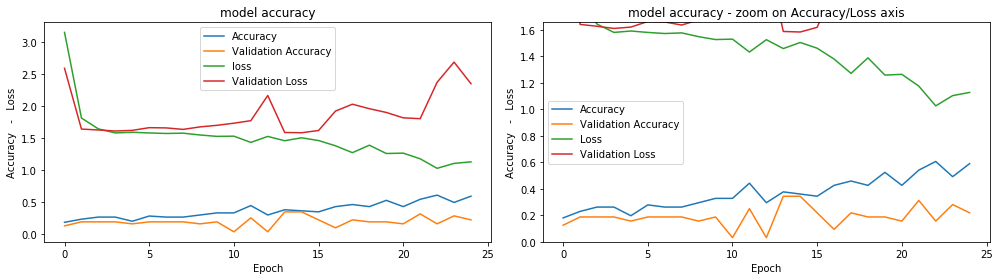

In [21]:
# Plot the coarse and fine versions of the model improvements

fig = plt.figure(figsize=(14,4))

ax1 = fig.add_subplot(1,2,1)

ax1.plot(m_history.history['accuracy'])
ax1.plot(m_history.history['val_accuracy'])
ax1.plot(m_history.history['loss'])
ax1.plot(m_history.history['val_loss'])
ax1.set_title("model accuracy")
ax1.set_ylabel("Accuracy   -   Loss")
ax1.set_xlabel("Epoch")
ax1.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])

# get ylimits and consider zooming in for the next plot
ylow, yhigh = ax1.get_ylim()

ax2 = fig.add_subplot(1,2,2)

ax2.plot(m_history.history['accuracy'])
ax2.plot(m_history.history['val_accuracy'])
ax2.plot(m_history.history['loss'])
ax2.plot(m_history.history['val_loss'])
ax2.set_title("model accuracy - zoom on Accuracy/Loss axis")
ax2.set_ylabel("Accuracy   -   Loss")
ax2.set_xlabel("Epoch")
ax2.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
ax2.set_ylim(0,yhigh/2)

print("Y-axis: Accuracy should improve from 0 to 1; Loss should decrease and ideally would reach 0.")
plt.tight_layout()

**Discussion of model plots**

The accuracy metrics 
 - Accuracy
 - Validation Accuracy    

should be climbing from a low value toward an **ideal value of 1** by the end of the training epochs.

While the training accuracy (blue) is going up, the validation accuracy (orange) is not. This indicates that the model is fitting or over-fitting (low bias) on the training data but is not performing well on the validation data (high variation).

The loss metrics    
- Loss 
- Validation Loss

may start at very high values but should be trending toward an **ideal value of 0** by the end of the training epochs.

While the training loss (green) is trending down, the validation loss (red) is fluctuating and then getting worse. 

Since the model will save the a checkpoint for the best validation accuracy, we are able to use either the final model or the checkpoint model for predictions.

In the current version of the model, the checkpoint model is expected to have better performance.

In [22]:
# save the model
model.save(filepath=final_model_full)   # this is a very large file -- > 1.5G

# save just the weights
model.save_weights(final_model_weights) # this is still a large file --> 500M

# Note that these are only for the final model; to save the weights for the 
# checkpoint model, we need to reload the model. This will be completed in the 
# next section.


## Utilities for predictions

In [43]:
# Show the images with the Actual and Predicted classifications
def evaluate_test_images(model_under_test, cat,image_test_dir,image_list,display_images = False):
    '''cat : name of image category
       img_list: list of images that should be in that category'''
    
    tot_images = len(image_list)
    tot_div_2 = (tot_images/2)+1

    if (display_images == True):
        fig = plt.figure(figsize=(14,4*tot_div_2)) # size for 2 columns

    img_num = 1
    ax_list = []
    fontsize = 20
    tot_images = len(image_list)

    list_true_labels = []
    list_pred_labels = []
    
    #print(f"Evaluating {image_test_dir} with {len(image_list)} images")

    for img_file in image_list:
        use_image = image_test_dir + '/' + img_file
        
        img = image.load_img(use_image,target_size=(224,224))
        img = np.asarray(img)
        
        if (display_images == True):
            ax = fig.add_subplot(tot_div_2,2,img_num)
            plt.imshow(img)


        img = np.expand_dims(img, axis=0)
        output = model_under_test.predict(img)
        best_match = np.argmax(output)

        if (display_images == True):
            title_str = "Actual: " + cat + '\n' + "Predicted: " + labels[best_match]
            ax.set_title(title_str,fontsize=fontsize)
            ax_list.append(ax)
            
        img_num += 1

        # save the labels for the confusion matrix
        list_true_labels.append(cat)
        list_pred_labels.append(labels[best_match])
        
    if (display_images == True):    
        plt.tight_layout()
        
    return list_true_labels, list_pred_labels

In [44]:
def model_prediction_eval(model_under_test, image_test_dir, labels, display_images = False):
    y_true_labels = []
    y_pred_labels = []

    for caty in labels:
        category_dir = image_test_dir + '/' + caty
        img_list = rm_DS(os.listdir(category_dir))
        print(f"Category {caty} has {len(img_list)} test images.")
        l_true, l_pred = evaluate_test_images(model_under_test,
                                              caty,
                                              category_dir,
                                              img_list,
                                              display_images)

        y_true_labels += l_true
        y_pred_labels += l_pred
        
    cm_array = confusion_matrix(y_true_labels, y_pred_labels)
    df = pd.DataFrame(cm_array, index = labels, columns=labels)
    
    return df, y_true_labels, y_pred_labels

## Metrics from model predictions

To do predictions on the last and best versions of the trained model, we will
- load the model 
- pre-process the image 
- pass the image to the model to get the prediction
- display the confusion matrix with the actual category and the predicted category

In [45]:
print(f"Checking the model on images in the test directory with catgories: \n\n{labels}")

Checking the model on images in the test directory with catgories: 

['depth_0', 'depth_1', 'depth_2', 'depth_3', 'depth_4']


#### Final or 'last' model

In [46]:
# Load and evaluate the final model
saved_model = load_model(final_model_full) # best model?

df, y_true_last, y_pred_last = model_prediction_eval(saved_model, 
                                                             image_test_dir, 
                                                             labels)

Category depth_0 has 2 test images.
Category depth_1 has 4 test images.
Category depth_2 has 4 test images.
Category depth_3 has 3 test images.
Category depth_4 has 3 test images.


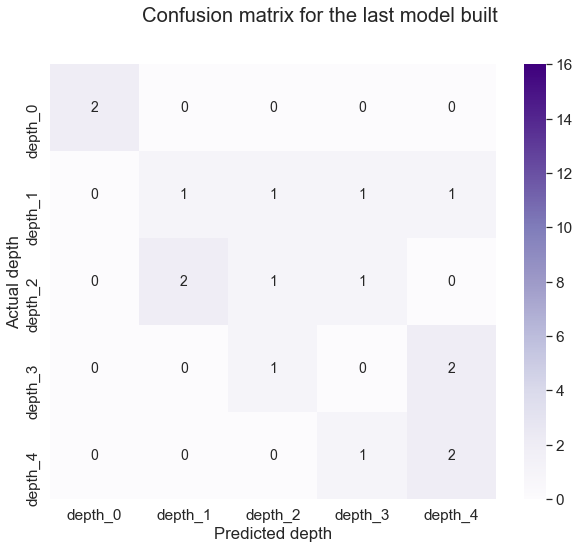

In [47]:
# Confusion matrix for the final model
plt.figure(figsize=(10,8))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df, cmap = 'Purples', annot=True, vmax = len(y_true_last),
            fmt="d", annot_kws={"size": 14}) # font size
plt.ylabel("Actual depth")
plt.xlabel("Predicted depth");
plt.suptitle("Confusion matrix for the last model built");

**Discussion**

The final model is the last version of the model when the full set of training epochs was completed. This is not necessarily the best model and should be compared with the checkpoint model evaluated below.

#### Checkpoint or 'best' model

Category depth_0 has 2 test images.
Category depth_1 has 4 test images.
Category depth_2 has 4 test images.
Category depth_3 has 3 test images.
Category depth_4 has 3 test images.


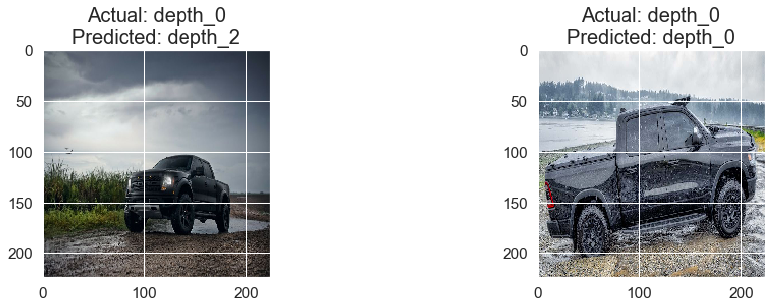

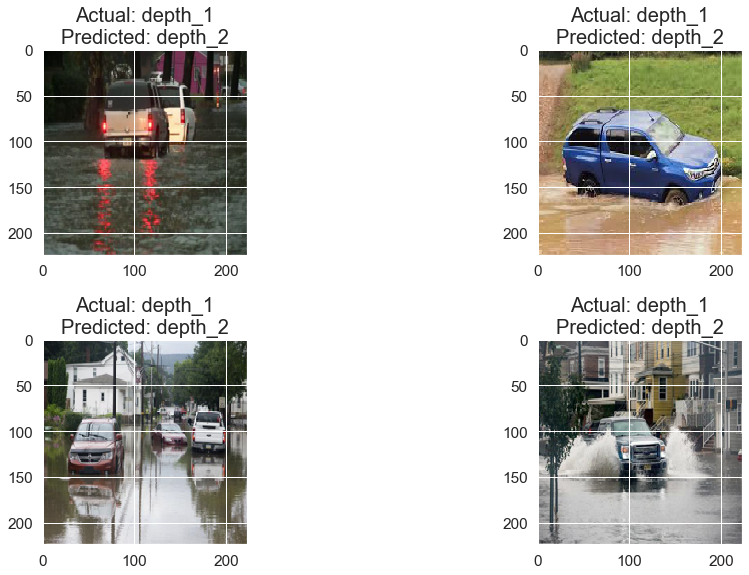

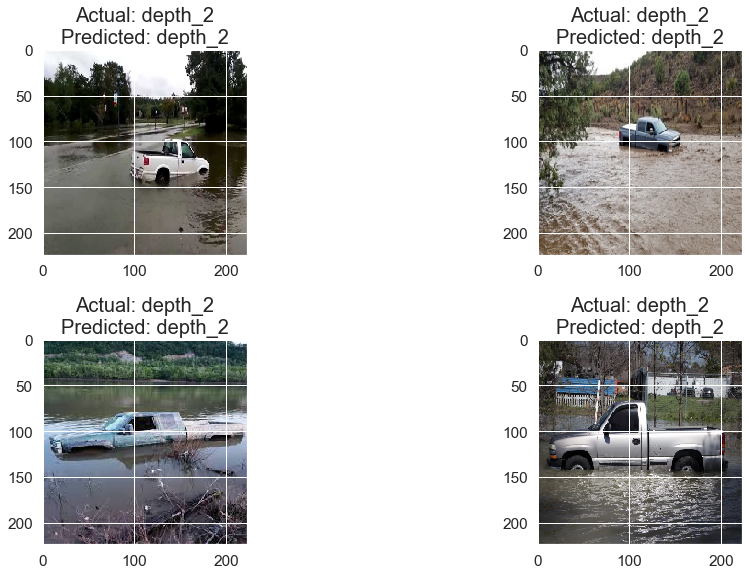

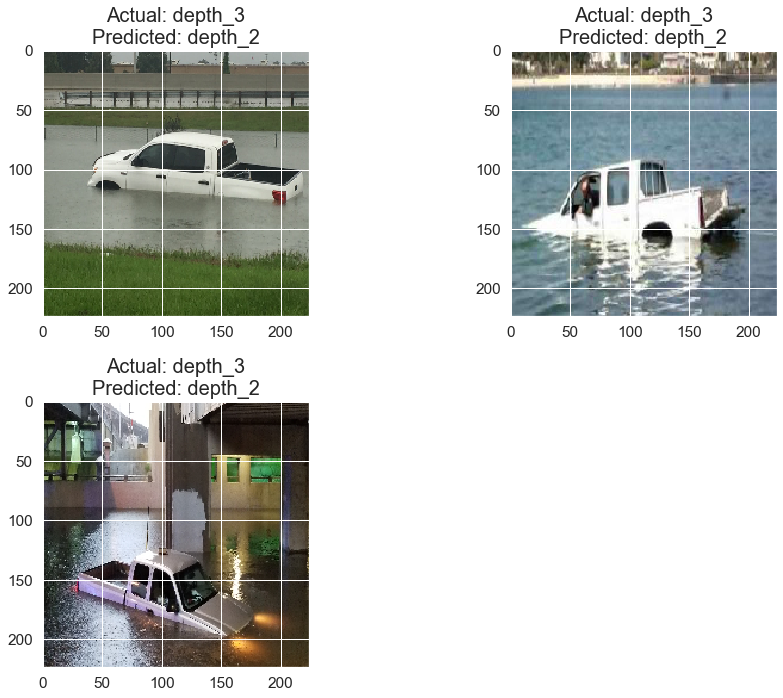

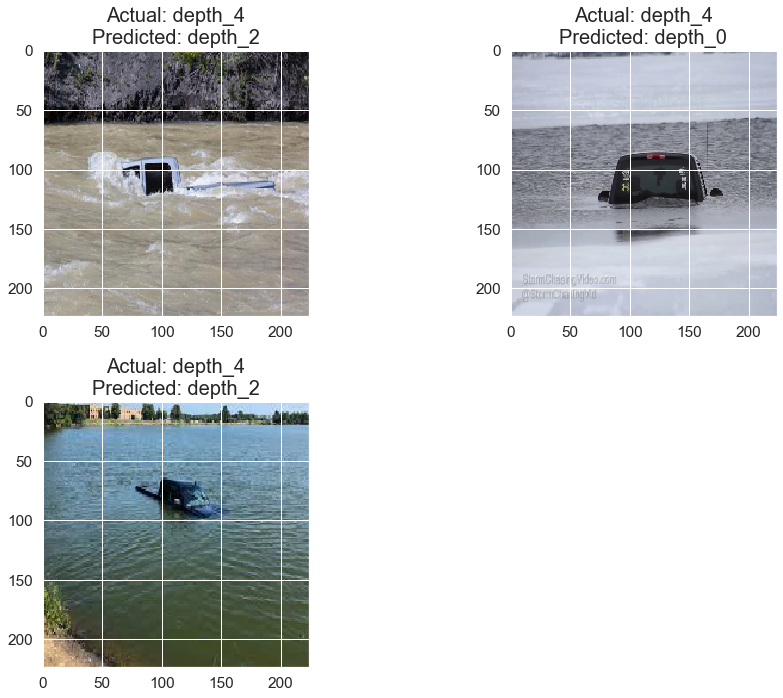

In [48]:
# Load and evaluate the best model
saved_model = load_model(checkpoint_model_full)

# save the checkpoint model weights
saved_model.save_weights(checkpoint_model_weights)

df, y_true_best, y_pred_best = model_prediction_eval(saved_model, 
                                                             image_test_dir, 
                                                             labels, True)

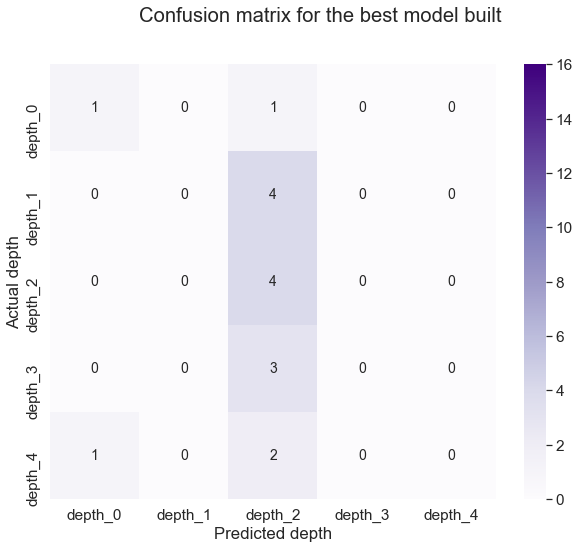

In [49]:
plt.figure(figsize=(10,8))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df, cmap = 'Purples', annot=True, vmax = len(y_true_best),
            fmt="d", annot_kws={"size": 14}) # font size
plt.ylabel("Actual depth")
plt.xlabel("Predicted depth");
plt.suptitle("Confusion matrix for the best model built");

In [50]:
print(classification_report(y_true_last, y_pred_last, target_names=labels))

              precision    recall  f1-score   support

     depth_0       1.00      1.00      1.00         2
     depth_1       0.33      0.25      0.29         4
     depth_2       0.33      0.25      0.29         4
     depth_3       0.00      0.00      0.00         3
     depth_4       0.40      0.67      0.50         3

    accuracy                           0.38        16
   macro avg       0.41      0.43      0.41        16
weighted avg       0.37      0.38      0.36        16



In [51]:
print(classification_report(y_true_best, y_pred_best, target_names=labels))

              precision    recall  f1-score   support

     depth_0       0.50      0.50      0.50         2
     depth_1       0.00      0.00      0.00         4
     depth_2       0.29      1.00      0.44         4
     depth_3       0.00      0.00      0.00         3
     depth_4       0.00      0.00      0.00         3

    accuracy                           0.31        16
   macro avg       0.16      0.30      0.19        16
weighted avg       0.13      0.31      0.17        16



**Discussion of model evaluation statistics**

The checkpoint model is better than the last trained model, and shows that there are opportunities for improving the model.

# 6. Conclusion

The model is struggling to identify some classes of images and is just above the baseline for others. 
We believe that there are several contributors:
    
- Limited data set -- Even with augmentation, this is a very small data set for building a classification model.
- "True" labels may not be exact. Without a larger data set to select from, there are several images that are not ideal examples of a single case. For example, a truck that is splashing through 1.5 feet of water can make it look like 1 foot or less where the water is displaced, and 2 feet where the front of the truck has pushed the water and created a bow wake.

Given these limitations, we consider the models and image pipeline 'proof of concept'. See the project README for some of the recomended next steps.

In [52]:
print("Model build and prelminary testing complete.")

Model build and prelminary testing complete.
